In [13]:
# 导入一个数据处理专用包，pandas
import pandas as pd
# 读取用户申购赎回数据表
user_balance= pd.read_csv('user_balance_table.csv',index_col='report_date')
# 根据report_date，进行求和
rawData = user_balance.groupby(by=['report_date']).sum()
# 去除该方案不用的列，只选择本次有用的列
purchaseRedeemData = rawData[['total_purchase_amt','total_redeem_amt']]
# 打印purchaseRedeemData
print(purchaseRedeemData)


             total_purchase_amt  total_redeem_amt
report_date                                      
20130701               32488348           5525022
20130702               29037390           2554548
20130703               27270770           5953867
20130704               18321185           6410729
20130705               11648749           2763587
...                         ...               ...
20140827              302194801         468164147
20140828              245082751         297893861
20140829              267554713         273756380
20140830              199708772         196374134
20140831              275090213         292943033

[427 rows x 2 columns]


In [14]:
# 只选择资金的流入数据
purchaseTrainData = purchaseRedeemData[['total_purchase_amt']]
# purchaseTrainData = purchaseRedeemData[['total_redeem_amt']]
# 将数据转换成时间序列格式，以便于后期处理
purchaseTrainData.index = pd.to_datetime(purchaseTrainData.index,format='%Y%m%d')
# 打印资金的流入出数据
print(purchaseTrainData)


             total_purchase_amt
report_date                    
2013-07-01             32488348
2013-07-02             29037390
2013-07-03             27270770
2013-07-04             18321185
2013-07-05             11648749
...                         ...
2014-08-27            302194801
2014-08-28            245082751
2014-08-29            267554713
2014-08-30            199708772
2014-08-31            275090213

[427 rows x 1 columns]


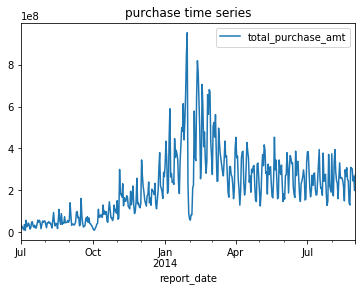

In [15]:
purchaseTrainData.sort_index().plot(title = 'purchase time series')

In [16]:
purchaseTrainSeries = purchaseTrainData.dropna().total_purchase_amt
# purchaseTrainSeries = purchaseTrainData.dropna().total_redeem_amt
print(purchaseTrainSeries)

report_date
2013-07-01     32488348
2013-07-02     29037390
2013-07-03     27270770
2013-07-04     18321185
2013-07-05     11648749
                ...    
2014-08-27    302194801
2014-08-28    245082751
2014-08-29    267554713
2014-08-30    199708772
2014-08-31    275090213
Name: total_purchase_amt, Length: 427, dtype: int64


In [17]:
from arch.unitroot import ADF

# 进行ADF单位根检验，并查看结果
# 最大滞后阶数设为10
# 防止使用的滞后阶数过多，导致 P-Value 偏低

print(ADF(purchaseTrainSeries,max_lags=10).summary())


   Augmented Dickey-Fuller Results   
Test Statistic                 -2.812
P-value                         0.057
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [18]:
purchaseTrainSeries_diff_1 = purchaseTrainSeries.diff().dropna()
print(ADF(purchaseTrainSeries_diff_1,max_lags=10).summary())


   Augmented Dickey-Fuller Results   
Test Statistic                 -9.890
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [19]:
from statsmodels.tsa import stattools

LjungBox=stattools.q_stat(stattools.acf(purchaseTrainSeries),len(purchaseTrainSeries))
print(LjungBox[1][-1])


0.0


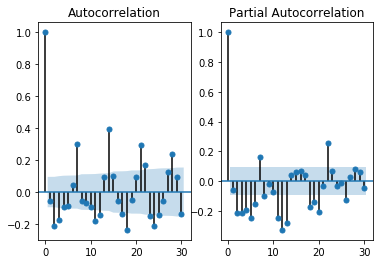

In [20]:
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
# 将画面一分为二
# 第一个画自相关图
# 第二个画偏自相关图


# 将画面一分为二
axe1=plt.subplot(121)
axe2=plt.subplot(122)
#在第一个画面中画出序列的自相关系数图 
plot1=plot_acf(purchaseTrainSeries_diff_1,lags=30,ax=axe1)
#在第二个画面中画出序列的偏自相关系数图
plot2=plot_pacf(purchaseTrainSeries_diff_1,lags=30,ax=axe2)



In [21]:
from statsmodels.tsa import arima_model
import sys

# 忽略 ValueWarning
import warnings
warnings.filterwarnings('ignore')

aicValue_Dif = sys.maxsize
p_Dif = 0
q_Dif = 0

for p in range(0,10):
    for q in range(0,10):
        try:
            model = arima_model.ARIMA(purchaseTrainSeries,order=(p,1,q)).fit()
            aicValue = model.aic
            print('p=' + str(p) + '   q=' + str(q) + '   aic=' + str(aicValue))
            if aicValue <  aicValue_Dif:
                aicValue_Dif = aicValue
                p_Dif = p
                q_Dif = q
        except:
            continue

print('p_Dif=' + str(p_Dif) + '   q_Dif=' + str(q_Dif)  +  '   aicValue_Dif=' + str(aicValue_Dif))

p=0   q=0   aic=16841.460203357445
p=0   q=1   aic=16840.65879097423
p=0   q=2   aic=16768.588254717608
p=0   q=3   aic=16749.329831759434
p=0   q=4   aic=16751.30918695687
p=1   q=0   aic=16841.9752200592
p=1   q=1   aic=16765.542397722962
p=1   q=2   aic=16753.108197276342
p=1   q=3   aic=16751.31043599223
p=1   q=4   aic=16747.349897647335
p=1   q=5   aic=16748.65322730327
p=1   q=6   aic=16748.649510872274
p=1   q=7   aic=16737.502410440025
p=2   q=0   aic=16823.96105890665
p=2   q=1   aic=16748.624487466237
p=2   q=2   aic=16748.745570131756
p=2   q=3   aic=16750.61328108457
p=2   q=4   aic=16694.1091691445
p=2   q=5   aic=16691.841441033826
p=2   q=6   aic=16692.582391077074
p=2   q=7   aic=16739.421124521665
p=3   q=0   aic=16806.12709020857
p=3   q=1   aic=16748.81160523667
p=3   q=2   aic=16750.667923907065
p=3   q=3   aic=16680.710558220406
p=3   q=4   aic=16682.411342380707
p=3   q=5   aic=16696.737577963024
p=3   q=6   aic=16693.266301524673
p=3   q=7   aic=16694.8554763846

In [22]:
model = arima_model.ARIMA(purchaseTrainSeries,order=(p_Dif,1,q_Dif)).fit()
model.conf_int()

,0,1
const,-574057.139553,1.713033e+06
ar.L1.D.total_purchase_amt,0.889514,1.354966e+00
ar.L2.D.total_purchase_amt,-0.870418,-4.231737e-02
ar.L3.D.total_purchase_amt,-0.855501,-6.567611e-02
ar.L4.D.total_purchase_amt,0.099214,5.247086e-01
ar.L5.D.total_purchase_amt,-0.305875,5.725320e-03
ar.L6.D.total_purchase_amt,-0.154534,1.375071e-01
ar.L7.D.total_purchase_amt,0.079106,3.607834e-01
ar.L8.D.total_purchase_amt,-0.387845,-1.969048e-01
ma.L1.D.total_purchase_amt,-1.770997,-1.307237e+00


In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

LjungBox = acorr_ljungbox(model.resid,lags=7)
print(LjungBox[1][-1])

0.8224153297170889


In [24]:
# 模型预测

model.forecast(30)[0]



array([3.20602370e+08, 3.29064069e+08, 3.08668266e+08, 2.56219469e+08,
       2.28279911e+08, 2.04336627e+08, 2.43177176e+08, 2.85565066e+08,
       3.14726712e+08, 3.00835833e+08, 2.63196878e+08, 2.31059012e+08,
       2.24282164e+08, 2.55558627e+08, 2.97021396e+08, 3.22568802e+08,
       3.09765823e+08, 2.71878537e+08, 2.36077189e+08, 2.28880169e+08,
       2.55678322e+08, 2.95792569e+08, 3.20424581e+08, 3.10989216e+08,
       2.76244566e+08, 2.42376573e+08, 2.35297597e+08, 2.60235728e+08,
       2.98813755e+08, 3.22812012e+08])